# Vision Transformer Implementation using Tensorflow



In [ ]:
!pip install tensorflow-addons

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import os
import cv2
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

/opt/conda/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.7.0 and strictly below 2.10.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.3 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [ ]:
def get_images(directory):
    Images = []
    Labels = []
    label = 0
    
    for labels in os.listdir(directory):
        if labels == 'glacier':
            label = 2
        elif labels == 'sea':
            label = 4
        elif labels == 'buildings':
            label = 0
        elif labels == 'forest':
            label = 1
        elif labels == 'street':
            label = 5
        elif labels == 'mountain':
            label = 3
        
        for image_file in os.listdir(directory+labels):
            image = cv2.imread(directory+labels+r'/'+image_file)
            image = cv2.resize(image,(150,150))
            Images.append(image)
            Labels.append(label)
    
    return shuffle(Images,Labels,random_state=817328462)

def get_classlabel(class_code):
    labels = {2:'glacier', 4:'sea', 0:'buildings', 1:'forest', 5:'street', 3:'mountain'}
    
    return labels[class_code]

In [ ]:
Images, Labels = get_images('../input/intel-image-classification/seg_train/seg_train/')

Images = np.array(Images)
Labels = np.array(Labels)

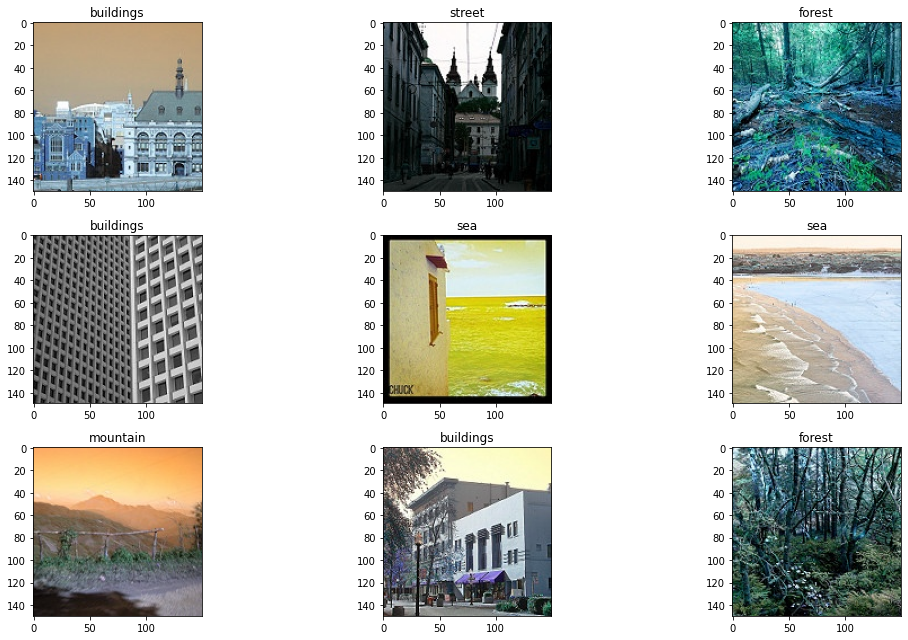

In [ ]:
plt.figure(figsize=(16,9))
for i in range(0, 9):
    plt.subplot(3,3,i+1)
    plt.imshow(Images[i])
    plt.title(get_classlabel(Labels[i]))
plt.tight_layout()

In [ ]:
patch_size = 6
num_patches = (150 // patch_size) ** 2
projection_dim = 64
transformer_units = [
    projection_dim * 2,
    projection_dim,
]
mlp_head_units = [2048, 1024]

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [ ]:
img = plt.imread("../input/intel-image-classification/seg_pred/seg_pred/10004.jpg")
img = tf.expand_dims(img,axis=0)
x = Patches(6)(img)
x.shape

2022-05-23 08:56:19.238956: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-23 08:56:19.381275: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-23 08:56:19.382566: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-23 08:56:19.385770: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

TensorShape([1, 625, 108])

In [ ]:
n = int(np.sqrt(x.shape[1]))
n

25

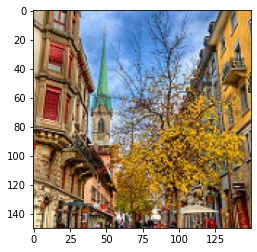

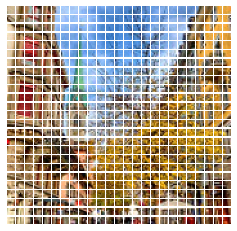

In [ ]:
plt.imshow(np.squeeze(img))

n = int(np.sqrt(x.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(x[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

# Vision Transformer Model Architecture : 

![Img](https://production-media.paperswithcode.com/methods/Screen_Shot_2021-01-26_at_9.43.31_PM_uI4jjMq.png)
![Img2](https://theaisummer.com/static/aa65d942973255da238052d8cdfa4fcd/7d4ec/the-transformer-block-vit.png)

In [ ]:
def create_vit_classifier(input_shape):
    inputs = layers.Input(shape=input_shape)
    patches = Patches(patch_size)(inputs)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    for _ in range(8):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=4, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        encoded_patches = layers.Add()([x3, x2])

    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    logits = layers.Dense(6)(features)
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
vit_classifier = create_vit_classifier((150,150,3))

In [ ]:
optimizer = tfa.optimizers.AdamW(
        learning_rate=0.001, weight_decay=0.0001
    )
vit_classifier.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'],
    )
vit_classifier.fit(Images, Labels ,epochs=100)

2022-05-23 08:56:53.219842: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 947295000 exceeds 10% of free system memory.
2022-05-23 08:56:54.164958: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 947295000 exceeds 10% of free system memory.
2022-05-23 08:56:54.870979: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
439/439 [==============================] - 127s 259ms/step - loss: 4.1945 - accuracy: 0.2510
Epoch 2/100
439/439 [==============================] - 114s 259ms/step - loss: 1.6843 - accuracy: 0.2511
Epoch 3/100
439/439 [==============================] - 114s 260ms/step - loss: 1.6693 - accuracy: 0.2540
Epoch 4/100
439/439 [==============================] - 114s 259ms/step - loss: 1.6381 - accuracy: 0.2714
Epoch 5/100
439/439 [==============================] - 114s 259ms/step - loss: 1.5762 - accuracy: 0.3042
Epoch 6/100
439/439 [==============================] - 114s 260ms/step - loss: 1.4927 - accuracy: 0.3654
Epoch 7/100
439/439 [==============================] - 114s 260ms/step - loss: 1.3028 - accuracy: 0.4231
Epoch 8/100
439/439 [==============================] - 114s 260ms/step - loss: 1.1915 - accuracy: 0.4607
Epoch 9/100
439/439 [==============================] - 114s 260ms/step - loss: 1.1190 - accuracy: 0.4849
Epoch 10/100
439/439 [==============================] -